In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Auto Claim Insights
##### We start by examining what factors contribute most to auto claim prices

In [2]:
auto_claims = pd.read_csv("./Downloads/Auto_Insurance_Claims_Sample.csv")
auto_claims.columns = [c.replace(' ', '_') for c in auto_claims.columns]  # Replace spaces in column names with '_'
print(auto_claims.info())    # Let's see what kind of factors we're examining
auto_claims

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   Country                        9134 non-null   object 
 2   State_Code                     9134 non-null   object 
 3   State                          9134 non-null   object 
 4   Claim_Amount                   9134 non-null   float64
 5   Response                       9134 non-null   object 
 6   Coverage                       9134 non-null   object 
 7   Education                      9134 non-null   object 
 8   Effective_To_Date              9134 non-null   object 
 9   EmploymentStatus               9134 non-null   object 
 10  Gender                         9134 non-null   object 
 11  Income                         9134 non-null   int64  
 12  Location_Code                  9134 non-null   o

,Customer,Country,State_Code,State,Claim_Amount,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Claim_Reason,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,...,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,...,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,...,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,...,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,...,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,US,MO,Missouri,2340.598798,No,Basic,Bachelor,2/10/11,Employed,...,89,0,2,Personal Auto,Personal L1,Hail,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,US,MO,Missouri,309.651122,Yes,Extended,College,2/12/11,Employed,...,28,0,1,Corporate Auto,Corporate L3,Collision,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,US,MO,Missouri,816.389043,No,Extended,Bachelor,2/6/11,Unemployed,...,37,3,2,Corporate Auto,Corporate L2,Collision,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,US,MO,Missouri,752.444244,No,Extended,College,2/3/11,Employed,...,3,0,3,Personal Auto,Personal L2,Scratch/Dent,Branch,691.200000,Four-Door Car,Large


##### Data Cleaning
We need all of this data to be represented as numbers. We will identify and assign integer values to unique values in columns we want to examine further.

In [4]:
# We want to remove columns that we don't think affect claim amount
# Recreate dataframe to have columns we want to examine
df = auto_claims[['State', 'Claim_Amount', 'Coverage', 'Education','EmploymentStatus', 'Gender', 'Income', 
                  'Location_Code', 'Monthly_Premium_Auto','Months_Since_Policy_Inception', 
                  'Policy', 'Claim_Reason', 'Vehicle_Class', 'Vehicle_Size', 'Total_Claim_Amount']]

print("Unique Values in Each Column")
for col in df.columns:
    num_unique = len(auto_claims[col].unique())
    print(col, num_unique)    # Number of unique values in each column
    if num_unique <= 10:
        print(auto_claims[col].unique())

Unique Values in Each Column
State 5
['Kansas' 'Nebraska' 'Oklahoma' 'Missouri' 'Iowa']
Claim_Amount 8041
Coverage 3
['Basic' 'Extended' 'Premium']
Education 5
['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
EmploymentStatus 5
['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Gender 2
['F' 'M']
Income 5694
Location_Code 3
['Suburban' 'Rural' 'Urban']
Monthly_Premium_Auto 202
Months_Since_Policy_Inception 100
Policy 9
['Corporate L3' 'Personal L3' 'Corporate L2' 'Personal L1' 'Special L2'
 'Corporate L1' 'Personal L2' 'Special L1' 'Special L3']
Claim_Reason 4
['Collision' 'Scratch/Dent' 'Hail' 'Other']
Vehicle_Class 6
['Two-Door Car' 'Four-Door Car' 'SUV' 'Luxury SUV' 'Sports Car'
 'Luxury Car']
Vehicle_Size 3
['Medsize' 'Small' 'Large']
Total_Claim_Amount 5106


In [5]:
# We'll convert non-int and non-float values to integers
df = df.apply(preprocessing.LabelEncoder().fit_transform)
df

,State,Claim_Amount,Coverage,Education,EmploymentStatus,Gender,Income,Location_Code,Monthly_Premium_Auto,Months_Since_Policy_Inception,Policy,Claim_Reason,Vehicle_Class,Vehicle_Size,Total_Claim_Amount
0,1,975,0,0,1,0,3322,1,8,5,2,0,5,1,2941
1,3,4659,1,0,4,0,0,1,32,42,5,3,0,1,4880
2,4,6900,2,0,1,0,2820,1,46,38,5,0,5,1,3897
3,2,5140,0,0,4,1,0,1,44,65,1,0,3,1,3764
4,1,1058,0,0,1,1,2510,0,12,44,3,0,0,1,1138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,2,7701,0,0,1,1,4331,2,12,89,3,1,0,1,1564
9130,2,1390,1,1,1,0,551,1,17,28,2,0,0,1,2902
9131,2,5516,1,0,4,1,0,1,23,37,1,0,0,1,4538
9132,2,5041,1,1,1,1,589,1,34,3,4,3,0,0,4304


In [6]:
X = df.iloc[:,0:13]  # We want the first 22 columns
y = df.iloc[:,14]    # Target column (Total Claim Amount)

exTree = ExtraTreesClassifier(n_estimators = 500, criterion = 'entropy', max_features = 'auto', max_leaf_nodes = None, max_depth = 18)


[0.05710079 0.10667156 0.07400603 0.08169484 0.03801205 0.05907935
 0.09151543 0.08536814 0.11660917 0.08942215 0.04773744 0.07374378
 0.07903926]


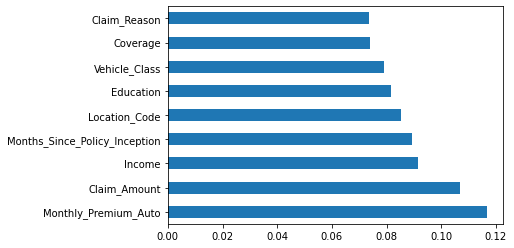

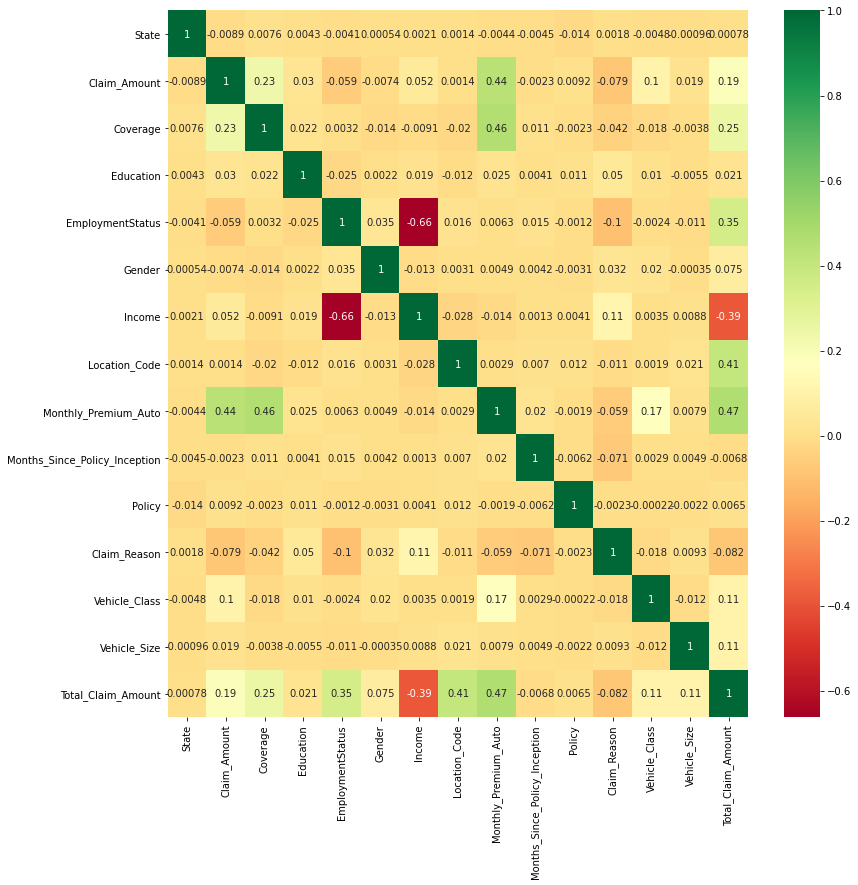

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = exTree.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

# get correlations of each feature in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(13,13))
# plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")